#### Import necesssary libraries

In [146]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
from nltk.corpus import wordnet

**Import the data set**

In [147]:
data=pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

In [148]:
data.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...


**Data Audit**

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
id                     5000 non-null object
dateAdded              5000 non-null object
dateUpdated            5000 non-null object
name                   5000 non-null object
asins                  5000 non-null object
brand                  5000 non-null object
categories             5000 non-null object
primaryCategories      5000 non-null object
imageURLs              5000 non-null object
keys                   5000 non-null object
manufacturer           5000 non-null object
manufacturerNumber     5000 non-null object
reviews.date           5000 non-null object
reviews.dateAdded      1052 non-null object
reviews.dateSeen       5000 non-null object
reviews.doRecommend    5000 non-null bool
reviews.id             29 non-null float64
reviews.numHelpful     5000 non-null int64
reviews.rating         5000 non-null int64
reviews.sourceURLs     5000 non-null object
reviews.text      

In [150]:
data.shape

(5000, 24)

In [151]:
data.isnull().sum()

id                        0
dateAdded                 0
dateUpdated               0
name                      0
asins                     0
brand                     0
categories                0
primaryCategories         0
imageURLs                 0
keys                      0
manufacturer              0
manufacturerNumber        0
reviews.date              0
reviews.dateAdded      3948
reviews.dateSeen          0
reviews.doRecommend       0
reviews.id             4971
reviews.numHelpful        0
reviews.rating            0
reviews.sourceURLs        0
reviews.text              0
reviews.title            13
reviews.username          0
sourceURLs                0
dtype: int64

**Renaming the columns (pythonic way of doing things)**

In [152]:
data.columns = [ i.replace('.', '_') for i in data.columns]

In [153]:
data.shape

(5000, 24)

In [154]:
data['reviews_rating'].value_counts()

5    3478
4    1208
3     197
1      63
2      54
Name: reviews_rating, dtype: int64

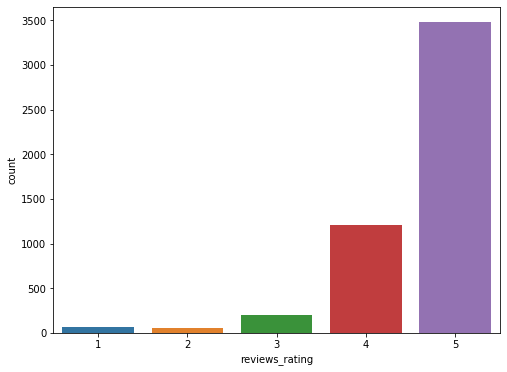

In [155]:
plt.figure(figsize=(8,6))
sns.countplot(data.reviews_rating)
plt.show()

#### Removing the unecessary columns

In [156]:
data.drop(['reviews_dateAdded','reviews_date','manufacturer','keys','categories','brand','asins','name','id'],axis=1,inplace=True)

In [157]:
data.drop(['reviews_username','reviews_title','reviews_sourceURLs'],axis=1,inplace=True)

In [158]:
data.drop(['reviews_numHelpful','reviews_id','reviews_doRecommend','reviews_dateSeen'],axis=1,inplace=True)

In [159]:
data.drop(['primaryCategories','imageURLs','manufacturerNumber','sourceURLs'],axis=1,inplace=True)

In [160]:
data.drop(['dateAdded','dateUpdated'],axis=1,inplace=True)

In [161]:
data.head()

,reviews_rating,reviews_text
0,3,I thought it would be as big as small paper bu...
1,5,This kindle is light and easy to use especiall...
2,4,Didnt know how much i'd use a kindle so went f...
3,5,I am 100 happy with my purchase. I caught it o...
4,5,Solid entry level Kindle. Great for kids. Gift...


**Checking for missing values**

In [162]:
data.isnull().sum()

reviews_rating    0
reviews_text      0
dtype: int64

**Dropping the missing values**

In [163]:
data.dropna(inplace=True)

In [164]:
data.isnull().sum()

reviews_rating    0
reviews_text      0
dtype: int64

In [165]:
data.shape

(5000, 2)

**Re-assigning the rating in terms of positive(5) and negative(1)**

In [166]:
data['reviews_rating']=np.where((data['reviews_rating']==5) | (data['reviews_rating']==4),5,1)

In [167]:
data['reviews_rating'].value_counts()

5    4686
1     314
Name: reviews_rating, dtype: int64

In [168]:
data.reviews_rating=data.reviews_rating.astype("int64")    

In [169]:
data.shape

(5000, 2)

### Sentiment Analysis to find positive and negative reviews

In [170]:
x = data['reviews_text']
y = data['reviews_rating']

In [171]:
x.head()

0    I thought it would be as big as small paper bu...
1    This kindle is light and easy to use especiall...
2    Didnt know how much i'd use a kindle so went f...
3    I am 100 happy with my purchase. I caught it o...
4    Solid entry level Kindle. Great for kids. Gift...
Name: reviews_text, dtype: object

#### Creating a user-defined function

In [172]:
def sentiment_review(text):
    analysis = TextBlob(text)
    polarity_text = analysis.sentiment.polarity
    if polarity_text > 0:
        return 'Positive'
    elif polarity_text == 0:
        return 'Neutral'
    else:
        return 'Negative'

#### creating dictionary which will contain both the review and the sentiment of the review

In [173]:
final_dictionary = []
for text in x:
    dictionary_sentiment = {}
    dictionary_sentiment['Review'] = text
    dictionary_sentiment['Sentiment'] = sentiment_review(text)
    final_dictionary.append(dictionary_sentiment)
print(final_dictionary[:5])

[{'Review': 'I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.', 'Sentiment': 'Negative'}, {'Review': 'This kindle is light and easy to use especially at the beach!!!', 'Sentiment': 'Positive'}, {'Review': "Didnt know how much i'd use a kindle so went for the lower end. im happy with it, even if its a little dark", 'Sentiment': 'Positive'}, {'Review': "I am 100 happy with my purchase. I caught it on sale at a really good price. I am normally a real book person, but I have a 1 year old who loves ripping up pages. The Kindle prevents that, it's extremely portable (it fits better in my purse than a giant book), and I have it loaded with lots of books. I finish one and start another, without having to go store. It serves all my needs. I picked this one over the Paperwhite because the price was unbeatable and the only difference th

**Finding positive reviews**

In [174]:
positive_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Positive':
        positive_reviews.append(review)
print(positive_reviews[:5])

[{'Review': 'This kindle is light and easy to use especially at the beach!!!', 'Sentiment': 'Positive'}, {'Review': "Didnt know how much i'd use a kindle so went for the lower end. im happy with it, even if its a little dark", 'Sentiment': 'Positive'}, {'Review': "I am 100 happy with my purchase. I caught it on sale at a really good price. I am normally a real book person, but I have a 1 year old who loves ripping up pages. The Kindle prevents that, it's extremely portable (it fits better in my purse than a giant book), and I have it loaded with lots of books. I finish one and start another, without having to go store. It serves all my needs. I picked this one over the Paperwhite because the price was unbeatable and the only difference that I could see was this one wasn't backlit. A simple book light from the Dollar tree solves that issue. This is my second Kindle (the first being the old Keyboard model, which I put down because I fell out of love with the keyboard. Lol) and it most li

**Finding neutral reviews**

In [175]:
neutral_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Neutral':
        neutral_reviews.append(review)
print(neutral_reviews[:5])

[{'Review': 'i bought this as a backup. I am currently using the same headphone.', 'Sentiment': 'Neutral'}, {'Review': 'it is smaller than i thought but it gets the job done.', 'Sentiment': 'Neutral'}, {'Review': 'My wife loves it, replaces a Kindle from like 2003.', 'Sentiment': 'Neutral'}, {'Review': 'My nephew is going to college next year and we want to give him a gift. Kindle suits it well for him to learn and study.', 'Sentiment': 'Neutral'}, {'Review': 'We bought this for mother in law, buying another for me.', 'Sentiment': 'Neutral'}]


**Finding negative reviews**

In [176]:
negative_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Negative':
        negative_reviews.append(review)
print(negative_reviews[:5])

[{'Review': 'I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.', 'Sentiment': 'Negative'}, {'Review': 'I bought my Kindle about 2 months ago and the battery is already dead and will not charge', 'Sentiment': 'Negative'}, {'Review': "It's beyond my expectation, and it can even show music score. Not fast turning though.", 'Sentiment': 'Negative'}, {'Review': "The battery doesn't last as long as was advertised, if you have the money I would recommend the backlit model.", 'Sentiment': 'Negative'}, {'Review': 'it would not load my books proper. took a dozen tries erasing an dreregistering. screen too dark', 'Sentiment': 'Negative'}]


**counting number of positive,neutral and negative reviews**

In [177]:
reviews_count = pd.DataFrame([len(positive_reviews),len(neutral_reviews),len(negative_reviews)],
                             index=['Positive','Neutral','Negative'])

In [178]:
reviews_count

,0
Positive,4471
Neutral,293
Negative,236


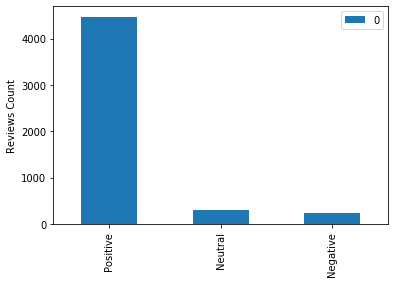

In [179]:
reviews_count.plot(kind='bar')
plt.ylabel('Reviews Count')   
plt.show()

**printing first five positive reviews**

In [180]:
i=1
for review in positive_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
This kindle is light and easy to use especially at the beach!!!
******************************************************
2
Didnt know how much i'd use a kindle so went for the lower end. im happy with it, even if its a little dark
******************************************************
3
I am 100 happy with my purchase. I caught it on sale at a really good price. I am normally a real book person, but I have a 1 year old who loves ripping up pages. The Kindle prevents that, it's extremely portable (it fits better in my purse than a giant book), and I have it loaded with lots of books. I finish one and start another, without having to go store. It serves all my needs. I picked this one over the Paperwhite because the price was unbeatable and the only difference that I could see was this one wasn't backlit. A simple book light from the Dollar tree solves that issue. This is my second Kindle (the first being the old Keyboard model, which I put down because I fell out of love with the keyboa

**printing first five negative reviews**

In [181]:
i=1
for review in negative_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.
******************************************************
2
I bought my Kindle about 2 months ago and the battery is already dead and will not charge
******************************************************
3
It's beyond my expectation, and it can even show music score. Not fast turning though.
******************************************************
4
The battery doesn't last as long as was advertised, if you have the money I would recommend the backlit model.
******************************************************
5
it would not load my books proper. took a dozen tries erasing an dreregistering. screen too dark
******************************************************


## Creating the corpus

In [182]:
import re
corpus = []
for i in range(0, len(x)):
    review = re.sub(r'\W', ' ', str(x[i]))
    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', '', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)

In [183]:
x[0]

'I thought it would be as big as small paper but turn out to be just like my palm. I think it is too small to read on it... not very comfortable as regular Kindle. Would definitely recommend a paperwhite instead.'

In [184]:
corpus[0]

'thought it would be as big as small paper but turn out to be just like my palm think it is too small to read on it not very comfortable as regular kindle would definitely recommend paperwhite instead '

**Using Lemmatizer**

In [185]:
from nltk.stem import WordNetLemmatizer
# sentences = nltk.sent_tokenize(paragraph)
lemmatizer = WordNetLemmatizer()

# Lemmatization
for i in range(len(corpus)):
    words = nltk.word_tokenize(corpus[i])
    words = [lemmatizer.lemmatize(word) for word in words]
    corpus[i] = ' '.join(words)

In [186]:
tokens_vect = CountVectorizer(stop_words='english')

In [187]:
token_dtm = tokens_vect.fit_transform(corpus)

In [188]:
tokens_vect.get_feature_names()[100:130]

['700',
 '720p',
 '75',
 '750',
 '76',
 '77',
 '78',
 '79',
 '7th',
 '7yr',
 '80',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '8g',
 '8gb',
 '8mm',
 '8th',
 '90',
 '911',
 '93',
 '95',
 '96',
 '99',
 '9the',
 '9yo']

In [189]:
token_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [190]:
token_dtm.toarray().shape

(5000, 4598)

In [191]:
len(tokens_vect.get_feature_names())

4598

## creating a dataframe which shows the count of how many times a word is coming in the corpus

In [192]:
count_dtm_dataframe = pd.DataFrame(np.sum(token_dtm.toarray(),axis=0),tokens_vect.get_feature_names()).reset_index()
count_dtm_dataframe.columns =['Word','Count']

In [193]:
count_dtm_dataframe.tail()

,Word,Count
4593,äúshow,1
4594,äúskills,1
4595,äústar,2
4596,äúthings,2
4597,ôºå,1


In [194]:
#adding sentiment column which shows sentiment polarity of each word
sentiment_word = []
for word in count_dtm_dataframe['Word']:
    sentiment_word.append(sentiment_review(word))
count_dtm_dataframe['Sentiment'] = sentiment_word

In [195]:
count_dtm_dataframe.head(5)

,Word,Count,Sentiment
0,00,6,Neutral
1,10,46,Neutral
2,100,21,Neutral
3,1000,2,Neutral
4,105,1,Neutral


In [196]:
# separating positive words
positive_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Positive',:].sort_values('Count',ascending=False)

In [197]:
positive_words_df.head(5)

,Word,Count,Sentiment
1865,great,1608,Positive
2469,love,1597,Positive
1354,easy,826,Positive
1821,good,676,Positive
2771,old,429,Positive


**plotting word cloud of 10 most frequently used positive words**

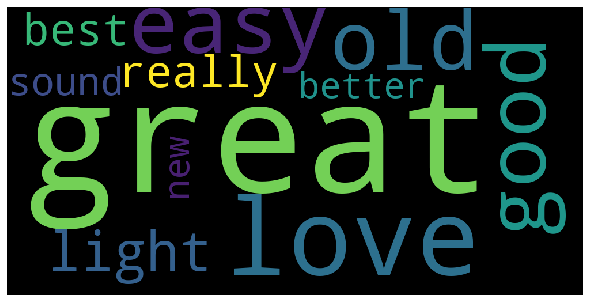

In [198]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positive_words_df.iloc[0:11,0]))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**separating negative words**

In [199]:
negative_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Negative',:].sort_values('Count',ascending=False)

In [200]:
negative_words_df.head(5)

,Word,Count,Sentiment
1763,game,389,Negative
2421,little,219,Negative
3697,small,127,Negative
2447,long,121,Negative
548,black,56,Negative


**plotting word cloud of 10 most frequently used negative words**

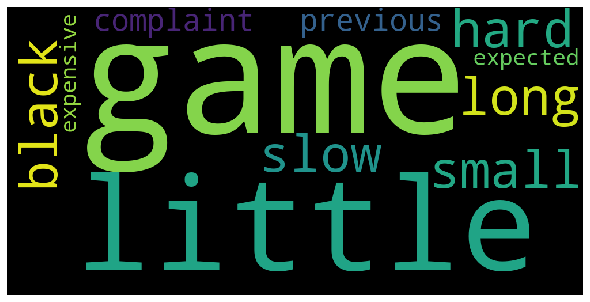

In [201]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negative_words_df.iloc[0:11,0]))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Topic Modelling

#### Splitting the data into train and test

In [202]:

train_x,test_x,train_y,test_y = train_test_split(x,y,random_state = 123, test_size = 0.2)

In [203]:
print('No.of observations in train_x: ',len(train_x), '| No.of observations in test_x: ',len(test_x))
print('No.of observations in train_y: ',len(train_y), '| No.of observations in test_y: ',len(test_y))

No.of observations in train_x:  4000 | No.of observations in test_x:  1000
No.of observations in train_y:  4000 | No.of observations in test_y:  1000


### Feature generation using TDM

In [204]:
vect_tdm = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1),min_df=0.001,max_df=0.95)

In [205]:
train_x_tdm = vect_tdm.fit_transform(train_x)
test_x_tdm = vect_tdm.transform(test_x)

In [206]:
print('No.of features for are',len(vect_tdm.get_feature_names()))

No.of features for are 1648


**creating dataframe to to see which features are present in the documents**

In [207]:
train_x_tdm_df = pd.DataFrame(train_x_tdm.toarray(),columns=vect_tdm.get_feature_names())

In [208]:
train_x_tdm_df.head()

,00,10,100,11,12,13,14,15,16,16gb,...,xmas,year,years,yes,yesterday,young,younger,youngest,youtube,yr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train a LDA Model

In [210]:
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=50)
x_topics = lda_model.fit_transform(train_x_tdm)
topic_word = lda_model.components_ 
vocab = vect_tdm.get_feature_names()

**view the topic models**

In [211]:
top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print(topic_words)

['kindle' 'tablet' 'bought' 'books' 'loves' 'great' 'read' 'daughter'
 'old' 'use']
['friend' 'christmas' 'picture' 'service' 'design' 'clear' 'dad' 'gift'
 'loving' 'sales']
['parental' 'controls' 'limit' 'properly' 'effective' 'multiple' 'covers'
 'possibly' 'heavy' 'smartphone']
['plenty' 'proof' 'figuring' 'presents' 'minimal' 'knowledge' 'effort'
 'super' '3rd' 'damaged']
['easy' 'use' 'love' 'mom' 'purchased' 'set' 'kindle' 'navigate' 'choose'
 'great']
['present' 'nephew' 'member' 'birthday' 'niece' 'holidays' 'loves' 'ages'
 'gift' 'takes']
['expected' 'web' 'worked' 'surfing' 'homework' 'just' 'automatically'
 'scroll' 'adjusts' 'pages']
['loves' 'old' 'year' 'grandson' 'son' 'bought' 'absolutely' 'father'
 'entertaining' 'game']
['great' 'good' 'product' 'tablet' 'price' 'recommend' 'happy' 'use'
 'easy' 'works']
['difficult' 'smaller' 'step' 'working' 'similar' 'helpful' 'associate'
 'hopefully' 'screens' 'hardware']
['tablets' 'limited' 'beautiful' 'problems' 'fi' 'wi' 'opt

In [212]:
# view the topic models
top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
topic_summaries

['kindle tablet bought books loves great read daughter old use',
 'friend christmas picture service design clear dad gift loving sales',
 'parental controls limit properly effective multiple covers possibly heavy smartphone',
 'plenty proof figuring presents minimal knowledge effort super 3rd damaged',
 'easy use love mom purchased set kindle navigate choose great',
 'present nephew member birthday niece holidays loves ages gift takes',
 'expected web worked surfing homework just automatically scroll adjusts pages',
 'loves old year grandson son bought absolutely father entertaining game',
 'great good product tablet price recommend happy use easy works',
 'difficult smaller step working similar helpful associate hopefully screens hardware',
 'tablets limited beautiful problems fi wi option personal android office',
 'camera answers operate link durable monitor incredible penny bedroom bumper',
 'pleased au turns performs steal versatile maneuver bargain capacity distracting',
 'age ap

### Building Model on TDM

**building naive bayes model on TDM**

In [213]:
# building naive bayes model on TDM
naive_model = MultinomialNB()
naive_model.fit(train_x_tdm,train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
predict_train = naive_model.predict(train_x_tdm)
predict_test = naive_model.predict(test_x_tdm)

In [215]:
print('Accuracy on train: ',metrics.accuracy_score(train_y,predict_train))
print('Accuracy on test: ',metrics.accuracy_score(test_y,predict_test))

Accuracy on train:  0.939
Accuracy on test:  0.947


In [216]:
# predict probabilities on train and test
predict_prob_train = naive_model.predict_proba(train_x_tdm)[:,1]
predict_prob_test = naive_model.predict_proba(test_x_tdm)[:,1]

In [217]:
print('ROC_AUC score on train: ',metrics.roc_auc_score(train_y,predict_prob_train))
print('ROC_AUC score on test: ',metrics.roc_auc_score(test_y,predict_prob_test))

ROC_AUC score on train:  0.9327745783628137
ROC_AUC score on test:  0.8355649518440217


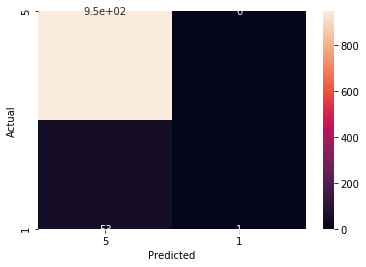

In [218]:
sns.heatmap(cm_test,annot=True,xticklabels=[5,1],yticklabels=[5,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Predicting star ratings using reviews

## Creating the Tf-Idf model

In [219]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 0.05, max_df = 0.8, stop_words = stopwords.words('english'))
x = vectorizer.fit_transform(corpus).toarray()

In [220]:
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.76318558,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.44924819],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [221]:
x.shape

(5000, 51)

## Apply Logistic regression

In [222]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(x,
                                              y,
                                              test_size=.3,
                                              random_state=42)

In [223]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit( train_x, train_y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Model Accuracy Evaluation**

In [143]:
#Evelution of train and test accuracy
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,logreg.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,logreg.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.9313333333333333
train_accuracy:  0.9397142857142857


Text(0.5, 15.0, 'Predicted label')

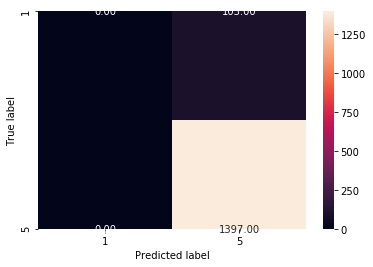

In [225]:
cm = metrics.confusion_matrix(test_y,
                            logreg.predict(test_x), [1,5] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["1", "5"] , yticklabels = ["1", "5"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Final Prediction

In [226]:
data.head(3)

,reviews_rating,reviews_text
0,1,I thought it would be as big as small paper bu...
1,5,This kindle is light and easy to use especiall...
2,5,Didnt know how much i'd use a kindle so went f...


#### Concatenating final prediction with original data set(all obersvations):

In [227]:
pred_stars=pd.DataFrame(logreg.predict(x),columns=['predicted_stars'])
  
testfile = pd.concat([data, pred_stars], axis=1)

testfile.tail(10)

,reviews_rating,reviews_text,predicted_stars
4990,5,Tablets are best used for personal reading. Cl...,5
4991,5,My son uses the device to help him do his home...,5
4992,5,My 6yr old son loves the tablet!I plan on purc...,5
4993,5,I APPRECIATE the ease of purchasing and readin...,5
4994,5,"I love this tablet/kindle. I can access email,...",5
4995,5,This is a great tablet for the price. Amazon i...,5
4996,5,This tablet is the perfect size and so easy to...,5
4997,5,Purchased this for my son. Has room to upgrade...,5
4998,5,I had some thoughts about getting this for a 5...,5
4999,5,"this is a steal, have 8 gb model as well.This ...",5
